В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
# def plot_data(X, y):
#     ax = plt.gca()
#     ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)
    
def plot_data(A, b, test = False):
    positive_indices = np.where(b == 1)[0]
    negative_indices = np.where(b == 0)[0]
    
    plt.scatter(A[positive_indices, 0], A[positive_indices, 1], marker='x', c= 'yellow' if test else 'green')
    plt.scatter(A[negative_indices, 0], A[negative_indices, 1], marker='+', c= 'blue' if test else 'red')

In [4]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    # hidden_layer_sizes=(100, 50,)
    def __init__(self, hidden_layer_sizes, normalize = True, learning_rate = 0.01, num_iter = 30000, batch_size=64, optimization='', momentum=0.9):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.optimization = optimization
        self.momentum = momentum
        self.batch_size = batch_size
        
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
    
        if mean is None:   
            mean = np.zeros([n, 1])
        if std is None:
            std  = np.ones([n, 1])
        
        for i in range(n):
            if (np.std(X[:, i]) != 0):
                if mean is None:
                    mean[i] = np.mean(X[:, i])
                if std is None:
                    std[i] = np.std(X[:, i])
        
        X_new = (X - mean) / std
        return X_new, mean, std
    

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __sigmoid_derivative(self, Z):
        z = self.__sigmoid(Z)
        return np.multiply(z, (1 - z))
    
    def __softmax(self, Z):
        exp_z = np.exp(Z)
        return exp_z / exp_z.sum(axis=0, keepdims=True)
    
    def __cross_entropy(self, A, Y):
        return - np.sum(Y * np.log(A), axis=1)
    
    def __initialize_parameters(self, n_x, n_y):
        self.parameters = {}
        n = len(n_x)
        
        for i in range(1, len(n_x)):
            W = np.random.randn(n_x[i], n_x[i - 1]) * 0.01
            b = np.zeros((n_x[i], 1))
            self.parameters.update({f"W{i}": W, f"b{i}": b})

        W = np.random.randn(n_y, n_x[n-1]) * 0.01
        b = np.zeros((n_y, 1))
        
        self.parameters.update({f"W{n}":W, f"b{n}":b})
                    
        for i in range(1, len(n_x) + 1):
            self.parameters.update({f"VdW{i}": 0, f"Vdb{i}": 0})
            
    def __forward_propagation(self, X):
        num_layers = len(self.hidden_layer_sizes)
        cache = self.parameters.copy()
        
        A = X
        for i in range(1, num_layers + 2):
            if i == num_layers + 1:
                W = self.parameters[f"W{i}"]
                b = self.parameters[f"b{i}"]
                Z = np.dot(W, A) + b
                A = self.__softmax(Z)
            else:            
                W = self.parameters[f"W{i}"]
                b = self.parameters[f"b{i}"]
                Z = np.dot(W, A) + b
                A = self.__sigmoid(Z)
            cache.update({f"Z{i}": Z})
            cache.update({f"A{i}": A})
        return A, cache

    def compute_cost(self, A, Y):
        J = -np.mean(Y.T * np.log(A.T))
        return J
    
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        num_layers = len(self.hidden_layer_sizes)
        
        grads = {}
        
        for i in range(num_layers+1, 0, -1):
            W = cache[f"W{i}"]
            b = cache[f"b{i}"]
            Z = cache[f"Z{i}"]
            if i == num_layers + 1:
                A = cache[f"A{i}"]
                A_next = cache[f"A{i - 1}"]
                
                dZ = A - Y
                dW = 1. / m * np.dot(dZ, A_next.T)
                db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
            elif (i == 1):
                W_prev = cache[f"W{i + 1}"]
                A = cache[f"A{i}"]
                
                dA = np.dot(W_prev.T, dZ)
                dZ = np.multiply(dA, self.__sigmoid_derivative(A))
                dW = 1. / m * np.dot(dZ, X.T)
                db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
            else:
                W_prev = cache[f"W{i + 1}"]
                A = cache[f"A{i}"]
                A_next = cache[f"A{i - 1}"]

                dA = np.dot(W_prev.T, dZ)
                dZ = np.multiply(dA, self.__sigmoid_derivative(A))
                dW = 1. / m * np.dot(dZ, A_next.T)
                db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
            grads.update({f"dZ{i}":dZ, f"dW{i}":dW, f"db{i}":db})
        return grads
    
    def __update_parameters(self, grads, iteration):
        num_layers = len(self.hidden_layer_sizes)
        
        for i in range(1, num_layers + 2):
            W = self.parameters[f"W{i}"]
            b = self.parameters[f"b{i}"]
            
            dW = grads[f"dW{i}"]
            db = grads[f"db{i}"]
            if self.optimization == 'momentum':
#                 print(1 - self.momentum ** iteration)
                self.parameters[f"VdW{i}"] = (self.momentum * self.parameters[f"VdW{i}"] + (1 - self.momentum) * dW / (1 - self.momentum ** (iteration + 1)))
                self.parameters[f"Vdb{i}"] = (self.momentum * self.parameters[f"Vdb{i}"] + (1 - self.momentum) * db / (1 - self.momentum ** (iteration + 1)))

                self.parameters[f"W{i}"] = W - self.learning_rate * self.parameters[f"VdW{i}"]
                self.parameters[f"b{i}"] = b - self.learning_rate * self.parameters[f"Vdb{i}"]

            else:
                self.parameters[f"W{i}"] = W - self.learning_rate * dW
                self.parameters[f"b{i}"] = b - self.learning_rate * db
    
    def fit(self, X_vert, Y_vert, epsilon=1e-08, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        m = X.shape[1]
        n_x = (X.shape[0],) + self.hidden_layer_sizes
        n_y = Y.shape[0]
        
        self.__initialize_parameters(n_x, n_y)
        
        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads, i)

            costs.append(cost)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))
                if i > 1:
                    print(f"Delta: {costs[-2] - costs[-1]}")

            if i > 1 and abs(costs[-2] - costs[-1]) < epsilon:
                break
                
        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()

    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        y_pred = self.likehood_func(positive_probs)
        return y_pred  

    def likehood_func(self, z):
        return z.argmax(axis=1)

Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [5]:
data_columns = ["Sepal length", "Sepal width", "Petal length", "Petal width"]
target_column = "Species"
df = pd.read_csv("iris.csv")
X, Y = df[data_columns].values, df[target_column].values.reshape((df.shape[0], 1))
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(150, 4), y=(150, 1)


In [6]:
from sklearn.preprocessing import OneHotEncoder

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)

encoder = OneHotEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train).toarray()
y_labels =  [ label[3:] for label in encoder.get_feature_names()]

print(type(y_train))
print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

<class 'numpy.ndarray'>
Training set: X=(120, 4), y=(120, 3)
Test set: X=(30, 4), y=(30, 1)


0-th iteration: 0.36617495056831456
1000-th iteration: 0.3194060954231787
Delta: 0.0001602118866282365
2000-th iteration: 0.19280858055263372
Delta: 5.884109899514933e-05
3000-th iteration: 0.15861331126534406
Delta: 2.0215727300043618e-05
4000-th iteration: 0.14457245784732592
Delta: 9.125478730692693e-06


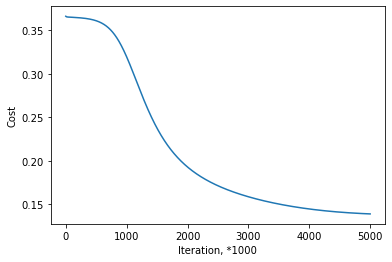

In [7]:
cls = NeuralNet((50, ), normalize = True, learning_rate = 0.01, num_iter = 5000)
cls.fit(X_train, y_train, epsilon=1e-15)

0-th iteration: 0.3669552079074792
1000-th iteration: 0.3248362001366707
Delta: 0.00015255067639763364
2000-th iteration: 0.192256189665576
Delta: 6.377528740098004e-05
3000-th iteration: 0.15661489362675504
Delta: 1.9790667708657894e-05
4000-th iteration: 0.14274811066111115
Delta: 9.653196858777635e-06


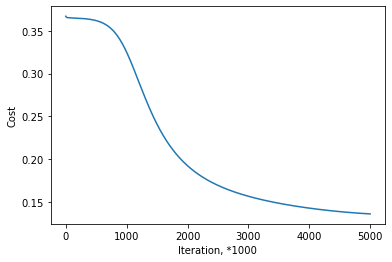

In [8]:
cls_momentum = NeuralNet((50, ), normalize = True, learning_rate = 0.01, num_iter = 5000,
                         optimization='momentum', momentum=0.3)
cls_momentum.fit(X_train, y_train, epsilon=1e-15)


#### No optimization

In [9]:
Y_hat = cls.predict(X_test)
Y_hat_labels = [y_labels[i] for i in Y_hat]
accuracy_score(y_test, Y_hat_labels)

0.9

#### Momentum

In [10]:
Y_hat = cls_momentum.predict(X_test)
Y_hat_labels = [y_labels[i] for i in Y_hat]
accuracy_score(y_test, Y_hat_labels)

0.9

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [11]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,10), max_iter = 11000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [12]:
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 10), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=11000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [13]:
Y_pred = clf.predict(X_test)
Y_pred_labels = [y_labels[np.argmax(i)] for i in Y_pred]
accuracy_score(y_test, Y_pred_labels)

0.9666666666666667